In [1]:
#import dependencies
import json
import csv
import pandas as pd
import numpy as np
import requests
import os
import matplotlib.pyplot as plt
from config import google_key
from config import weather_key
import time
from citipy import citipy
import datetime

In [2]:
lats = np.random.uniform(low=-90.000, high=90.000, size=2500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=2500)
lngs

array([ 139.04877255, -178.41280853, -129.89128959, ..., -162.58455186,
        -59.26928924,   50.25340223])

In [3]:
#loop through coordinates
#perform rough filter to remove most of ocean and antarctic coordinates
#used this map to find regions of ocean/antarctica https://www.colorado.edu/geography/gcraft/notes/coordsys/gif/georef.gif
not_in_tests_coordinate_pairs = []
for i in range(len(lats)):
    antarctic = (lats[i] < -60)
    pacific1 = (lats[i] < 10) and (lngs[i]<-95)
    pacific2 = (lats[i]>0 and lats[i] < 45) and (lngs[i]<-130)
    pacific3 = (lats[i]>0 and lats[i] < 45) and (lngs[i]>150)
    indian = (lats[i] < 5) and (lngs[i]>55 and lngs[i]<95)
    atlantic1 = (lats[i]>10 and lats[i] < 45) and (lngs[i]>-60 and lngs[i]<-20)
    atlantic2 = (lats[i] < 5) and (lngs[i]>-35 and lngs[i]<5)
    if ~antarctic and ~pacific1 and ~pacific1 and ~pacific3 and ~indian and ~atlantic1 and ~atlantic2:
        not_in_tests_coordinate_pairs.append([lats[i], lngs[i]])

#not_in_tests_coordinate_pairs_test = not_in_tests_coordinate_pairs[:5]
len(not_in_tests_coordinate_pairs)

1558

In [4]:
#save data so that you don't have to refilter data
not_in_tests_coordinate_pairs_df = pd.DataFrame(not_in_tests_coordinate_pairs)
not_in_tests_coordinate_pairs_df.to_csv('not_in_tests_coordinate_pairs.csv',index=False)

In [5]:
#load filtered data
not_in_tests_coordinate_pairs_df = pd.read_csv('not_in_tests_coordinate_pairs.csv')
not_in_tests_coordinate_pairs = []
for i in range(len(not_in_tests_coordinate_pairs_df)):
    not_in_tests_coordinate_pairs.append([not_in_tests_coordinate_pairs_df.iloc[i,0],not_in_tests_coordinate_pairs_df.iloc[i,1]])
len(not_in_tests_coordinate_pairs)

1558

In [6]:
#use google timezone api to remove ocean coordinates
coordinate_pairs = []
url = 'https://maps.googleapis.com/maps/api/timezone/json?'
for coordinate_pair in not_in_tests_coordinate_pairs:
    params = {'key':google_key,
         'timestamp':time.time(),
         'location':f'{coordinate_pair[0]}, {coordinate_pair[1]}'}
    response = requests.get(url,params=params).json()
    if len(response.keys()) != 1:
        coordinate_pairs.append(coordinate_pair)
len(coordinate_pairs)  

682

In [7]:
#save data so that you don't need to re call google api
coordinate_pairs_df = pd.DataFrame(coordinate_pairs)
coordinate_pairs_df.to_csv('coordinate_pairs_to_test.csv',index=False)

In [8]:
#load data so that you don't need to re call google api
coordinate_pairs_df = pd.read_csv('coordinate_pairs_to_test.csv')
coordinate_pairs = []
for i in range(len(coordinate_pairs_df)):
    coordinate_pairs.append([coordinate_pairs_df.iloc[i,0],coordinate_pairs_df.iloc[i,1]])
len(coordinate_pairs)

682

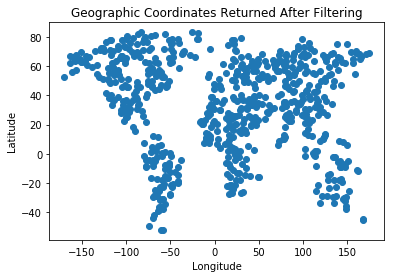

In [30]:
#show distribution of geographic coordinates used to grab weather data
plt.scatter(coordinate_pairs_df.iloc[:,1],coordinate_pairs_df.iloc[:,0])
plt.title("Geographic Coordinates Returned After Filtering")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [10]:
city_list = []
for coordinate_pair in coordinate_pairs:
    city = citipy.nearest_city(coordinate_pair[0],coordinate_pair[1])
    city_list.append([city.city_name,city.country_code])

len(city_list)

682

In [11]:
city_list

[['iskateley', 'ru'],
 ['sidi ali', 'dz'],
 ['nenjiang', 'cn'],
 ['talnakh', 'ru'],
 ['lasa', 'cn'],
 ['sanming', 'cn'],
 ['viedma', 'ar'],
 ['te anau', 'nz'],
 ['irtyshskiy', 'ru'],
 ['luza', 'ru'],
 ['baykit', 'ru'],
 ['tiznit', 'ma'],
 ['coachella', 'us'],
 ['khatanga', 'ru'],
 ['luancheng', 'cn'],
 ['yar-sale', 'ru'],
 ['gbadolite', 'cd'],
 ['cassia', 'br'],
 ['kouroussa', 'gn'],
 ['san lazaro', 'py'],
 ['albany', 'au'],
 ['antsohihy', 'mg'],
 ['oktyabrskoye', 'ru'],
 ['catamarca', 'ar'],
 ['chara', 'ru'],
 ['illoqqortoormiut', 'gl'],
 ['yabelo', 'et'],
 ['lorengau', 'pg'],
 ['hoshiarpur', 'in'],
 ['nizhneyansk', 'ru'],
 ['khandyga', 'ru'],
 ['pangnirtung', 'ca'],
 ['karema', 'tz'],
 ['kuytun', 'ru'],
 ['emborion', 'gr'],
 ['zhuanghe', 'cn'],
 ['cap-aux-meules', 'ca'],
 ['upernavik', 'gl'],
 ['thompson', 'ca'],
 ['ciudad real', 'es'],
 ['koutiala', 'ml'],
 ['rairangpur', 'in'],
 ['litovko', 'ru'],
 ['bangarmau', 'in'],
 ['san fernando', 'ph'],
 ['kabare', 'cd'],
 ['urumqi', 'cn'],


In [12]:
results_columns = ['City','Latitude','Longitude','Temperature','Humidity','Cloudiness','Wind Speed']
results_index = list(range(len(city_list)))
results = pd.DataFrame(columns=results_columns,index=results_index)
url = 'http://api.openweathermap.org/data/2.5/weather?'
count = 0
for index,city in enumerate(city_list):
    params = {'units':'imperial',"appid":weather_key,'q':f'{city[0]},{city[1]}'}
    response = requests.get(url,params).json()
    print(f'Processing coordinate pair: {index} for city: {city[0]},{city[1]}')
    if len(response.keys()) != 2:    
        count = count + 1
        lat = response['coord']['lat']
        lng = response['coord']['lon']
        temp = response['main']['temp']
        humidity = response['main']['humidity']
        wind_speed = response['wind']['speed']
        cloud_cover = response['clouds']['all']
        results_row = {'City':city[0],
                       'Latitude':lat,
                       'Longitude':lng,
                       'Temperature':temp,
                       'Humidity':humidity,
                       'Cloudiness':cloud_cover,
                       'Wind Speed':wind_speed}
        results.iloc[count] = results_row
results

Processing coordinate pair: 0 for city: iskateley,ru
Processing coordinate pair: 1 for city: sidi ali,dz
Processing coordinate pair: 2 for city: nenjiang,cn
Processing coordinate pair: 3 for city: talnakh,ru
Processing coordinate pair: 4 for city: lasa,cn
Processing coordinate pair: 5 for city: sanming,cn
Processing coordinate pair: 6 for city: viedma,ar
Processing coordinate pair: 7 for city: te anau,nz
Processing coordinate pair: 8 for city: irtyshskiy,ru
Processing coordinate pair: 9 for city: luza,ru
Processing coordinate pair: 10 for city: baykit,ru
Processing coordinate pair: 11 for city: tiznit,ma
Processing coordinate pair: 12 for city: coachella,us
Processing coordinate pair: 13 for city: khatanga,ru
Processing coordinate pair: 14 for city: luancheng,cn
Processing coordinate pair: 15 for city: yar-sale,ru
Processing coordinate pair: 16 for city: gbadolite,cd
Processing coordinate pair: 17 for city: cassia,br
Processing coordinate pair: 18 for city: kouroussa,gn
Processing coor

Processing coordinate pair: 155 for city: hay river,ca
Processing coordinate pair: 156 for city: miraflores,co
Processing coordinate pair: 157 for city: adrar,dz
Processing coordinate pair: 158 for city: te anau,nz
Processing coordinate pair: 159 for city: urdoma,ru
Processing coordinate pair: 160 for city: salmas,ir
Processing coordinate pair: 161 for city: canberra,au
Processing coordinate pair: 162 for city: havre-saint-pierre,ca
Processing coordinate pair: 163 for city: sao desiderio,br
Processing coordinate pair: 164 for city: kindu,cd
Processing coordinate pair: 165 for city: grand centre,ca
Processing coordinate pair: 166 for city: nauta,pe
Processing coordinate pair: 167 for city: marawi,sd
Processing coordinate pair: 168 for city: severnoye,ru
Processing coordinate pair: 169 for city: cherskiy,ru
Processing coordinate pair: 170 for city: tazovskiy,ru
Processing coordinate pair: 171 for city: soskovo,ru
Processing coordinate pair: 172 for city: san fernando,mx
Processing coordi

Processing coordinate pair: 307 for city: iqaluit,ca
Processing coordinate pair: 308 for city: urdzhar,kz
Processing coordinate pair: 309 for city: kargasok,ru
Processing coordinate pair: 310 for city: la rioja,ar
Processing coordinate pair: 311 for city: norman wells,ca
Processing coordinate pair: 312 for city: shestakovo,ru
Processing coordinate pair: 313 for city: qaanaaq,gl
Processing coordinate pair: 314 for city: pangody,ru
Processing coordinate pair: 315 for city: naica,mx
Processing coordinate pair: 316 for city: burdur,tr
Processing coordinate pair: 317 for city: jiuquan,cn
Processing coordinate pair: 318 for city: qaanaaq,gl
Processing coordinate pair: 319 for city: sao felix do xingu,br
Processing coordinate pair: 320 for city: kodiak,us
Processing coordinate pair: 321 for city: moree,au
Processing coordinate pair: 322 for city: bereznik,ru
Processing coordinate pair: 323 for city: store heddinge,dk
Processing coordinate pair: 324 for city: krasnotorka,ua
Processing coordina

Processing coordinate pair: 457 for city: thompson,ca
Processing coordinate pair: 458 for city: beberibe,br
Processing coordinate pair: 459 for city: bossembele,cf
Processing coordinate pair: 460 for city: chaman,pk
Processing coordinate pair: 461 for city: nanjing,cn
Processing coordinate pair: 462 for city: jalu,ly
Processing coordinate pair: 463 for city: mamboma,sl
Processing coordinate pair: 464 for city: acuna,mx
Processing coordinate pair: 465 for city: tawang,in
Processing coordinate pair: 466 for city: yellowknife,ca
Processing coordinate pair: 467 for city: nizwa,om
Processing coordinate pair: 468 for city: sangar,ru
Processing coordinate pair: 469 for city: kiunga,pg
Processing coordinate pair: 470 for city: stephenville,us
Processing coordinate pair: 471 for city: manaus,br
Processing coordinate pair: 472 for city: hovd,mn
Processing coordinate pair: 473 for city: saint george,us
Processing coordinate pair: 474 for city: khatanga,ru
Processing coordinate pair: 475 for city:

Processing coordinate pair: 609 for city: xichang,cn
Processing coordinate pair: 610 for city: rudbar,af
Processing coordinate pair: 611 for city: gornyy,ru
Processing coordinate pair: 612 for city: ojo caliente,mx
Processing coordinate pair: 613 for city: catamarca,ar
Processing coordinate pair: 614 for city: yellowknife,ca
Processing coordinate pair: 615 for city: sidi ali,dz
Processing coordinate pair: 616 for city: woodward,us
Processing coordinate pair: 617 for city: mehamn,no
Processing coordinate pair: 618 for city: fairbanks,us
Processing coordinate pair: 619 for city: bonfim,br
Processing coordinate pair: 620 for city: kondinskoye,ru
Processing coordinate pair: 621 for city: atar,mr
Processing coordinate pair: 622 for city: kenai,us
Processing coordinate pair: 623 for city: vavoua,ci
Processing coordinate pair: 624 for city: kilemary,ru
Processing coordinate pair: 625 for city: riyadh,sa
Processing coordinate pair: 626 for city: saint-ambroise,ca
Processing coordinate pair: 62

,City,Latitude,Longitude,Temperature,Humidity,Cloudiness,Wind Speed
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,iskateley,67.68,53.15,21.52,86,76,15.01
2,nenjiang,49.18,125.22,-26.78,41,0,3.94
3,talnakh,69.49,88.4,-16.25,95,36,3.15
4,sanming,26.25,117.62,51.08,100,100,2.71
5,viedma,-40.81,-63,67.55,36,0,15.79
6,te anau,-45.42,167.72,37.08,91,56,2.93
7,irtyshskiy,58.33,68.13,23.58,91,76,5.39
8,luza,60.63,47.25,34.12,87,88,13.89
9,baykit,61.67,96.37,-8.68,62,92,3.71


In [22]:
date_time_now = datetime.datetime.now()
print(f'Analysis performed: {datetime.datetime.now()}')

Analysis performed: 2017-11-18 12:45:10.822430


In [14]:
results = results.dropna()
results.to_csv('results.csv',index=False)
len(results)

585

In [15]:
#load results so that you don't need to re call openweather api
results = pd.read_csv('results.csv')
len(results)

585

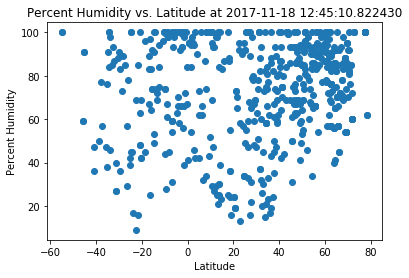

In [23]:
#plot Humidity vs. Latitude
plt.scatter(results["Latitude"],results["Humidity"])
plt.xlabel("Latitude")
plt.ylabel("Percent Humidity")
plt.title(f"Percent Humidity vs. Latitude at {date_time_now}")
plt.savefig("humidity_vs_latitude.png")
plt.show()

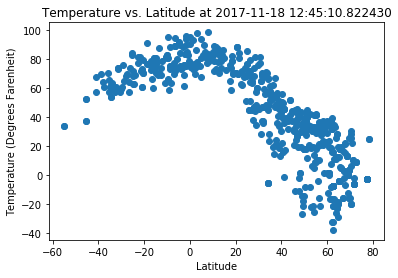

In [25]:
#plot Temperature vs. Latitude
plt.scatter(results["Latitude"],results["Temperature"])
plt.xlabel("Latitude")
plt.ylabel("Temperature (Degrees Farenheit)")
plt.title(f"Temperature vs. Latitude at {date_time_now}")
plt.savefig("temperature_vs_latitude.png")
plt.show()

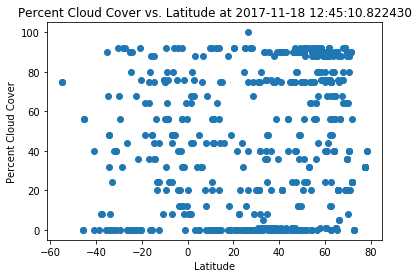

In [26]:
#plot Cloud Cover vs. Latitude
plt.scatter(results["Latitude"],results["Cloudiness"])
plt.xlabel("Latitude")
plt.ylabel("Percent Cloud Cover")
plt.title(f"Percent Cloud Cover vs. Latitude at {date_time_now}")
plt.savefig("cloud_cover_vs_latitude.png")
plt.show()

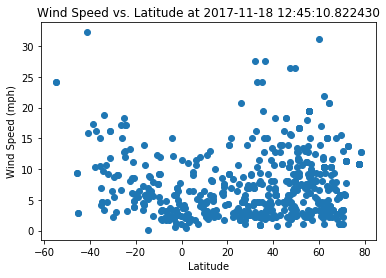

In [27]:
#plot Wind Speed vs. Latitude
plt.scatter(results["Latitude"],results["Wind Speed"])
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Wind Speed vs. Latitude at {date_time_now}")
plt.savefig("wind_speed_vs_latitude.png")
plt.show()

## Observable Trends

1) A greater range of latitiudes are sampled for the northern hemisphere than the souther hemisphere because we have settled more cities near the north pole.

2) The percent cloud cover versus latitude appears to be random in nature.

3) Wind speed versus Latitude appears to have more extreme outliers than the other plots displayed

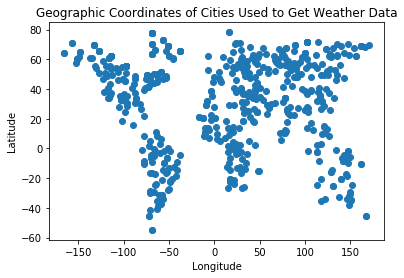

In [31]:
#plot geographic coordinates of cities returned by citipy
plt.scatter(results["Longitude"],results["Latitude"])
plt.title("Geographic Coordinates of Cities Used to Get Weather Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()